# Modeling Energy Levels with Neural Networks

In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where we aim to select a class from a list of classes.

This notebook uses the ENSDF Dataset and builds a model to predict the level energy of several isotopes. To do this, we'll provide the model with a description of many expeirmentally measrued values and accepted values. This description includes attributes like: # of neutrons, # of protons, and Atomic Mass.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from  IPython import display
import pathlib
import shutil
import tempfile
import os

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 50)
sns.set_style("darkgrid")

2.0.0


In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  2


In [4]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12161089293195894504, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6614766059
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15961977565128705903
 physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:42:00.0, compute capability: 7.5", name: "/device:GPU:1"
 device_type: "GPU"
 memory_limit: 6618563871
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 18415073097058226938
 physical_device_desc: "device: 1, name: GeForce RTX 2060 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5"]

# Getting the Data: Cross Sections

In [25]:
# print("Reading data into dataframe...")
# df = pd.read_csv("./ENSDF/ensdf_v2_2.csv")
# print("Data read into dataframe!")

# # Converting specific columns to datatype 'string'
# str_cols = ["Spin", "Parity", "Element_w_A"]
# df[str_cols] = df[str_cols].astype('category')

# # Converting remaining columns to numeric type. 
# for col in list(df.columns):
#     if col not in str_cols:
#         df[col] = df[col].astype(float)

# # Converting proton, neutron and mass number features to integers
# int_cols = ["Level_Number", "Target_Protons", "Target_Neutrons"]
# df[int_cols] = df[int_cols].astype(int)

# basic_cols = ["Level_Number", "Level_Energy", "Target_Protons", "Target_Neutrons", "Atomic_Mass_Micro", "Element_w_A"]
# df = df[basic_cols]

In [31]:
print("Reading data into dataframe...")
df = pd.read_csv("./ENSDF/ensdf_v2_2.csv")
print("Data read into dataframe!")

Reading data into dataframe...
Data read into dataframe!


In [32]:
df.shape

(21355, 8)

In [33]:
df.columns

Index(['Level_Number', 'Level_Energy', 'Protons', 'Neutrons',
       'Atomic_Mass_Micro', 'Element_w_A', 'Level_Energy_SQRT',
       'Level_Number_SQRT'],
      dtype='object')

# Known Upper Levels 

In [34]:
print("Reading data into dataframe...")
df2 = pd.read_csv("./ENSDF/ensdf_v1_2.csv")
print("Data read into dataframe!")

Reading data into dataframe...
Data read into dataframe!


In [35]:
df2.shape

(72668, 8)

In [ ]:
df.drop(columns=["Level_Energy_SQRT", "Level_Number_SQRT"], inplace=True)
df2.drop(columns=["Level_Energy_SQRT", "Level_Number_SQRT"], inplace=True)

In [36]:
sns.set(font_scale=2)

# Evaluating Predictions

Two very important measures that are often used in Statistics to determine the accuracy of a model are:

> **R^2 / R-squared**:  also known as the coefficient of determination, is a measure to indicate how close the data is to the fitted regression line. The value of the R-squared is the percentage of variation of the response variable (y) that is explained by a linear model.

> **Mean Squared Error (MSE)**: measures the average of the squares of errors, that is, the difference between actual value (y) and the estimated value (ŷ).
 

In [38]:
from sklearn.metrics import mean_squared_error, r2_score

# Creating Training, Validation, and Testing Datasets

In [39]:
from sklearn.model_selection import train_test_split

In [48]:
train_size = 0.8
test_size = 1 - 0.8
# x_train, x_test, y_train, y_test = train_test_split(
#     df.drop(columns=["Level_Energy", "Element_w_A"], axis=1), df["Level_Energy"], test_size=0.20)

x_train, x_test, y_train, y_test = train_test_split(
    df.drop(columns=["Level_Energy", "Level_Energy_SQRT", "Level_Number_SQRT", "Element_w_A"], axis=1), 
    df["Level_Energy"], test_size=0.20)

# Data Standarization 

For DT, normalization does not matter generally. However, for other algorithms like simple/multiple linear regression, neural networks, and k-clustering magnitudes of different features can create unexpected biases towards features with larger magnitudes.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [50]:
from sklearn import preprocessing

In [51]:
df.columns

Index(['Level_Number', 'Level_Energy', 'Protons', 'Neutrons',
       'Atomic_Mass_Micro', 'Element_w_A', 'Level_Energy_SQRT',
       'Level_Number_SQRT'],
      dtype='object')

In [52]:
x_train.columns

Index(['Level_Number', 'Protons', 'Neutrons', 'Atomic_Mass_Micro'], dtype='object')

In [53]:
# Specify columns to scale
to_scale = list(x_train.columns)
scaler = preprocessing.StandardScaler().fit(x_train[to_scale])

In [54]:
x_train[to_scale] = scaler.transform(x_train[to_scale])
x_test[to_scale] = scaler.transform(x_test[to_scale])

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

# Prediction and Plotting Function

The following functions will be used to easily use the traine model to visualize the results on a particular isotope with a specific reaction type. 

In [55]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    ''' Flexibly plot a univariate distribution of observations. '''
    plt.figure(figsize=(12, 10))
    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)
    plt.yscale('log')
    plt.xscale('log')
    plt.title(Title)
    plt.xlabel('Level Energy (MeV)')
    plt.ylabel('Proportion of Data')
    plt.show()

In [85]:
def plot_levels_axh(protons, neutrons, df, save=False):
    to_plot = df[(df["Protons"] == protons) & (df["Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=False)
    plt.figure(figsize=(10,15))
    for i in to_plot["Level_Energy"].values:
        plt.axhline(i, c="r", alpha=0.7)
    plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
    plt.ylabel('Energy (MeV)')
    plt.xticks([], [])
    if save == True:
        plt.savefig(figure_dir + 'ENSDF_{}_AXH_Level_Density.png'.format(to_plot.Element_w_A.iloc[0]), bbox_inches='tight')
    
def plot_levels_sctr(protons, neutrons, df):
    to_plot = df[(df["Protons"] == protons) & (df["Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=False)
    plt.figure(figsize=(15,10))
    sns.scatterplot(to_plot["Level_Number"], to_plot["Level_Energy"], alpha=0.5, label="True")
    plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
    plt.ylabel('Energy (MeV)')
    
def plot_levels_density(protons, neutrons, binning, df):
    to_plot = df[(df["Protons"] == protons) & (df["Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=False)
    plt.figure(figsize=(15,10))
        
    count, division = np.histogram(to_plot.Level_Energy, bins=binning)
    to_plot.Level_Energy.hist(bins=division)

    plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
    plt.xlabel('Energy (MeV)')
binning = []
binning.extend(np.arange(0,14,0.2))

def plot_level_density(protons, neutrons, df, df2=pd.DataFrame(), save=False):
    to_plot = df[(df["Protons"] == protons) & (df["Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=True)
    plt.figure(figsize=(15,10))
    to_plot["N"] = np.cumsum(to_plot.Level_Number)
    plt.plot(to_plot.Level_Energy, to_plot.N, c='blue', label="Adopted")
    if df2.shape[0] != 0:
        to_plot_2 = df2[(df2["Protons"] == protons) & (df2["Neutrons"] == neutrons)].sort_values(
            by='Level_Number', ascending=True)
        to_plot_2["N"] = np.cumsum(to_plot_2.Level_Number)
        plt.plot(to_plot_2.Level_Energy, to_plot_2.N, c='green', label="Cut-Off")
    plt.yscale('log')
    plt.title("Level Density for {}: {} Protons, {} Neutrons".format(to_plot.Element_w_A.iloc[0] ,protons, neutrons))
    plt.ylabel("N (Number of Levels)")
    plt.legend()
    plt.xlabel("Energy (MeV)")
    if save == True:
        plt.savefig(figure_dir + 'ENSDF_{}_Level_Density.png'.format(to_plot.Element_w_A.iloc[0]), bbox_inches='tight')

In [152]:
figure_dir = "./Figures/ENSDF_NN_GPU/"

In [153]:
def predicting_nuclear_xs(protons, neutrons, clf, N=0, adopted=False, tf_dataset=False, save=False, name="Name"):
    ''' 
    Used to plot predictions of the clf model for specific isotope (Z, N).
    '''
    # Extracting dataframe to make predictions and creating copy for evaluation
    to_plot = df[(df["Protons"] == protons) & (df["Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=True).drop(columns=["Element_w_A"])
    to_infer = df[(df["Protons"] == protons) & (df["Neutrons"] == neutrons)].sort_values(
        by='Level_Number', ascending=True).drop(columns=["Level_Energy", "Element_w_A"])
    
    if N != 0:
        last_level = to_plot.Level_Number.iloc[-1]
        level_range = np.arange(last_level, last_level + N , 1)
        to_infer2 = pd.DataFrame({"Level_Number": level_range})
        for i in list(to_infer.columns)[1:]:
                to_infer2[i] = to_infer[i].values[1]
        to_infer = to_infer.append(to_infer2, ignore_index=True).sort_values(by='Level_Number', ascending=True)
        level_density_df = to_infer.copy()
        
    if adopted == True:
        to_plot_2 = df2[(df2["Protons"] == protons) & (df2["Neutrons"] == neutrons) & (df2["Level_Number"] >= last_level)].sort_values(
            by='Level_Number', ascending=True).drop(
            columns=["Element_w_A"])
    
    # Applying standard scaler method 
    to_infer[to_scale] = scaler.transform(to_infer[to_scale])
        
    infer_dataset = tf.data.Dataset.from_tensor_slices(
        (to_infer.values)).batch(len(to_infer))
    y_hat  = clf.predict(infer_dataset)

    # Returning features to original values for plotting
    to_infer[to_scale] = scaler.inverse_transform(to_infer[to_scale])
        
    # Initializing Figure and Plotting 
    plt.figure(figsize=(16,10))
    true = plt.scatter(to_plot["Level_Number"], to_plot["Level_Energy"], alpha=0.3, c='r')
    if adopted == True:
        adopted_plot = plt.scatter(to_plot_2["Level_Number"], to_plot_2["Level_Energy"], alpha=0.3, c='b')
    pred = plt.scatter(to_infer["Level_Number"], y_hat.flatten(), alpha=0.5, label="Pred", c="g")
    plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
    plt.ylabel('Level Energy (MeV)')
    plt.xlabel('Level Number')
    if adopted == True:
        plt.legend((true, adopted_plot, pred), ('ENSDF Cut-Off', "ENSDF Adopted","NN ENSDF Pred"), loc='upper left')    
    else:
        plt.legend((true, pred), ('ENSDF Cut-Off',"NN ENSDF Pred"), loc='upper left')    
    all_y = np.concatenate((to_plot["Level_Energy"], y_hat.flatten()))
    minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
    maximum_y = all_y.max() + all_y.max() * 0.05
    plt.ylim(minimum_y, maximum_y)
    if save == True:
        plt.savefig(figure_dir + "{}_{}_{}_Linear.png".format(protons, neutrons, name), bbox_inches="tight")
        plt.close()
    
    if N != 0:
        print("XS Tree vs EXFOR:")
        print("The MSE is: ", mean_squared_error(to_plot["Level_Energy"], y_hat.flatten()[:last_level]))
        print("The R2-Score is: ", r2_score(to_plot["Level_Energy"], y_hat.flatten()[:last_level]))
    else:
        print("XS Tree vs EXFOR:")
        print("The MSE is: ", mean_squared_error(to_plot["Level_Energy"], y_hat.flatten()))
        print("The R2-Score is: ", r2_score(to_plot["Level_Energy"], y_hat.flatten()))    

    if (N != 0 and adopted == True):
        plt.figure(figsize=(15,10))
        level_density_df["N"] = np.cumsum(level_density_df.Level_Number)
        plt.plot(to_plot.Level_Energy, to_plot.Level_Number, c='red', label="Cut-Off")
        plt.plot(to_plot_2.Level_Energy, to_plot_2.Level_Number, c='blue', label="Adopted")
        plt.plot(y_hat.flatten(), level_density_df.N, c='green', label="Predicted")
        plt.yscale('log')
        plt.title("Level Density for: {} Protons, {} Neutrons".format(protons, neutrons))
        plt.ylabel("N (Number of Levels)")
        plt.legend()
        plt.xlabel("Energy (MeV)")
        if save == True:
            plt.savefig(figure_dir + "{}_{}_{}_Density.png".format(protons, neutrons, name), bbox_inches="tight")
            plt.close()
    elif (N != 0 and adopted == False):
        plt.figure(figsize=(15,10))
        level_density_df["N"] = np.cumsum(level_density_df.Level_Number)
        plt.plot(to_plot.Level_Energy, to_plot.Level_Number, c='red', label="Cut-Off")
        plt.plot(y_hat.flatten(), level_density_df.N, c='green', label="Predicted")
        plt.yscale('log')
        plt.title("Level Density for: {} Protons, {} Neutrons".format(protons, neutrons))
        plt.ylabel("N (Number of Levels)")
        plt.legend()
        plt.xlabel("Energy (MeV)")  
        if save == True:
            plt.savefig(figure_dir + "{}_{}_{}_Density.png".format(protons, neutrons, name), bbox_inches="tight")
            plt.close()
    else:
        plt.figure(figsize=(15,10))
        level_density_df["N"] = np.cumsum(level_density_df.Level_Number)
        plt.plot(y_hat.flatten(), level_density_df.N, c='green', label="Predicted")
        plt.yscale('log')
        plt.title("Level Density for: {} Protons, {} Neutrons".format(protons, neutrons))
        plt.ylabel("N (Number of Levels)")
        plt.legend()
        plt.xlabel("Energy (MeV)")  
        if save == True:
            plt.savefig(figure_dir + "{}_{}_{}_Density.png".format(protons, neutrons, name), bbox_inches="tight")
            plt.close()

# Neural Networks

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

If the model is not complex enough and its left training for emore than necessary the accuracy of the model stagnates or start decreasing. This is a sympton of overfitting. Overfit often translates to higher accuracies on the training dataset but does not generalize well to a testing set. The opposite is underfiting (not trained for long enough or the model is not complex enough) meaning model not powerful enough or over regularized. 

The network needs to learn relevant patters in the data. If training for too long it learns the weights to memorize and not model the data. We need to strike a balance between both. How many epochs do we train for? How much regularization?

Prevent overfitting by:
- More complete training data (dataset must cover full range of inputs that it is expected to handle).
- Additional data is needed to cover other cases
- If no more data gathering is possible we need to use regularization
- Regularization places constraints on the quantity and type of information your model can store.

At the end is all about learnable parameters which is determined by the # of layers and the units per layer. The number of learnable parameters is referred to as the models capacity. It is apparent that we can increase the models capacity to a point that it learns a perfect dictionary-like-mapping between datapoints and their targets but with no generalization power (useless on unseen data). 

If model is not complex enough it will learn compresssed representations which is not able to generalize well. There is a balance between too much and not much capacity. There is no methodology or formula to determine arquitecture size. We start with very few layers and parameteres and slowly increase the size of layers until we see diminishing validation loss

The strategy.scope() indicates part of the code to run distributed, creating model inside scope allows us to create mirrored vairables, compiling under the scope tells TF our intend to train model using this strategy.

In [59]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

# Optimization - Learning Rate

A gradually reducing learning rate with time performes better (jumping around). The `schedules.InverseTimeDecay` decreases rate hyperbolicallly to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 and so on.

# Compile and Fit Funciton - TensorBoard Logs

In [60]:
def get_optimizer(lr_schedule):
    return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200), # val_loss
        tf.keras.callbacks.TensorBoard(logdir/name)]

def compile_and_fit(model, name, train_dataset, test_dataset, STEPS_PER_EPOCH, BATCH_SIZE=None, 
                    optimizer=None, max_epochs=10000, DECAY_EPOCHS=1000):
    lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
        0.001, decay_steps=STEPS_PER_EPOCH*DECAY_EPOCHS,
        decay_rate=1, staircase=False)
    
    if optimizer is None:
        optimizer = get_optimizer(lr_schedule)
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae', 'mse'])
    model.summary()
    history = model.fit(
        train_dataset,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=test_dataset,
        callbacks=get_callbacks(name),
        verbose=0)        
    return history

In [61]:
cpu_strategy = tf.distribute.OneDeviceStrategy(device="/CPU:0")
single_gpu_strategy =  tf.distribute.OneDeviceStrategy(device="/GPU:0")
gpu_strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
print('Number of devices: {}'.format(gpu_strategy.num_replicas_in_sync))

Number of devices: 2


# Create a tf.data.Dataset Generator

The larger the `BATCH_SIZE`, the more efficient TensorFlow operates. 

In [62]:
N_VALIDATION = len(x_test)
N_TRAIN = len(x_train)
BUFFER_SIZE = N_TRAIN
BATCH_SIZE = 500
FEATURES = len(x_train.columns)

In [63]:
def tf_dataset_gen(x, y, xt, yt, BUFFER_SIZE, BATCH_SIZE, gpu=False, multiplier=0, cache=False):
    if gpu == True:
        BATCH_SIZE = BATCH_SIZE * multiplier
        print("GPU: ON")
    train_dataset = tf.data.Dataset.from_tensor_slices((x.values, y.values)).shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices((xt.values, yt.values)).batch(BATCH_SIZE)
    if cache == True: # Ensures loader doesnt re-read data at each epoch.
        train_dataset = train_dataset.cache()
        test_dataset = test_dataset.cache()
    STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
    print("BATCH SIZE: ", BATCH_SIZE)
    print("STEPS PER EPOCH: ", STEPS_PER_EPOCH)
    return train_dataset, test_dataset, STEPS_PER_EPOCH, BATCH_SIZE

In [64]:
train_dataset, test_dataset, STEPS_PER_EPOCH_CPU, BATCH_SIZE_CPU = tf_dataset_gen(
    x_train, y_train, x_test, y_test, BUFFER_SIZE, BATCH_SIZE)

BATCH SIZE:  500
STEPS PER EPOCH:  34


In [65]:
train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, BATCH_SIZE_GPU = tf_dataset_gen(
    x_train, y_train, x_test, y_test, BUFFER_SIZE, 1000, gpu=True, multiplier=2)

GPU: ON
BATCH SIZE:  2000
STEPS PER EPOCH:  8


# Training Models

In [66]:
size_histories = {}
size_histories_gpu = {}

In [139]:
%%time
with cpu_strategy.scope():
    tiny_model = tf.keras.Sequential([
        layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
        layers.Dense(1)])
    size_histories['Tiny_CPU'] = compile_and_fit(tiny_model, 'sizes/Tiny_CPU', train_dataset, 
                                                 test_dataset, STEPS_PER_EPOCH_CPU, max_epochs=5000)

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_123 (Dense)            (None, 16)                80        
_________________________________________________________________
dense_124 (Dense)            (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:9.1340,  mae:2.0972,  mse:9.1340,  val_loss:8.5447,  val_mae:1.9613,  val_mse:8.4087,  
....................................................................................................
Epoch: 100, loss:1.5174,  mae:0.8820,  mse:1.5174,  val_loss:1.8168,  val_mae:0.9155,  val_mse:1.7534,  
....................................................................................................
Epoch: 200, loss:1.2319,  mae:0.8298,  mse:1.2319,  val_loss:1.4765,  val_mae:0.8528,  val_mse:1.4320,  
...

....................................................................................................
Epoch: 3700, loss:0.9495,  mae:0.7506,  mse:0.9495,  val_loss:1.1017,  val_mae:0.7721,  val_mse:1.0827,  
....................................................................................................
Epoch: 3800, loss:0.9485,  mae:0.7509,  mse:0.9485,  val_loss:1.1019,  val_mae:0.7728,  val_mse:1.0829,  
....................................................................................................
Epoch: 3900, loss:0.9774,  mae:0.7572,  mse:0.9774,  val_loss:1.0994,  val_mae:0.7714,  val_mse:1.0805,  
....................................................................................................
Epoch: 4000, loss:0.9605,  mae:0.7515,  mse:0.9605,  val_loss:1.0985,  val_mae:0.7708,  val_mse:1.0798,  
....................................................................................................
Epoch: 4100, loss:0.9668,  mae:0.7545,  mse:0.9668,  val_loss:1.0981,  

In [76]:
%%time
with gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(16, activation='elu', input_shape=(FEATURES,)), 
                                      layers.Dense(1)])
    size_histories['Tiny_GPU_E_1000'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU_ELU_1000', 
                                                 train_dataset_gpu, test_dataset_gpu, 
                                                      STEPS_PER_EPOCH_GPU, max_epochs=5000, DECAY_EPOCHS=1000)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:8.1290,  mae:2.1966,  mse:8.1290,  val_loss:7.4304,  val_mae:2.1871,  val_mse:8.4684,  
....................................................................................................
Epoch: 100, loss:1.7577,  mae:0.9183,  mse:1.7577,  val_loss:1.8874,  val_mae:0.9597,  val_mse:2.0539,  
....................................................................................................
Epoch: 200, loss:1.6460,  mae:0.9013,  mse:1.6460,  val_loss:1.7739,  val_mae:0.9432,  val_mse:1.9318,  
....

....................................................................................................
Epoch: 3700, loss:1.0036,  mae:0.7681,  mse:1.0036,  val_loss:0.9947,  val_mae:0.7838,  val_mse:1.1238,  
....................................................................................................
Epoch: 3800, loss:1.0108,  mae:0.7679,  mse:1.0108,  val_loss:0.9915,  val_mae:0.7828,  val_mse:1.1204,  
....................................................................................................
Epoch: 3900, loss:0.9921,  mae:0.7610,  mse:0.9921,  val_loss:0.9882,  val_mae:0.7819,  val_mse:1.1173,  
....................................................................................................
Epoch: 4000, loss:0.9978,  mae:0.7636,  mse:0.9978,  val_loss:0.9869,  val_mae:0.7816,  val_mse:1.1155,  
....................................................................................................
Epoch: 4100, loss:0.9966,  mae:0.7639,  mse:0.9966,  val_loss:0.9841,  

In [77]:
%%time
with gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(16, activation='elu', input_shape=(FEATURES,)), 
                                      layers.Dense(1)])
    size_histories['Tiny_GPU_E_500'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU_ELU_500', 
                                                 train_dataset_gpu, test_dataset_gpu, 
                                                      STEPS_PER_EPOCH_GPU, max_epochs=5000, DECAY_EPOCHS=500)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:7.2373,  mae:1.9376,  mse:7.2373,  val_loss:6.6418,  val_mae:1.9241,  val_mse:7.5297,  
....................................................................................................
Epoch: 100, loss:1.7231,  mae:0.9320,  mse:1.7231,  val_loss:1.8755,  val_mae:0.9719,  val_mse:2.0403,  
....................................................................................................
Epoch: 200, loss:1.5686,  mae:0.8999,  mse:1.5686,  val_loss:1.7759,  val_mae:0.9505,  val_mse:1.9306,  
....

....................................................................................................
Epoch: 3700, loss:1.0667,  mae:0.7851,  mse:1.0667,  val_loss:1.0760,  val_mae:0.8014,  val_mse:1.2065,  
....................................................................................................
Epoch: 3800, loss:1.0760,  mae:0.7848,  mse:1.0760,  val_loss:1.0744,  val_mae:0.8009,  val_mse:1.2049,  
....................................................................................................
Epoch: 3900, loss:1.0637,  mae:0.7835,  mse:1.0637,  val_loss:1.0727,  val_mae:0.8007,  val_mse:1.2032,  
....................................................................................................
Epoch: 4000, loss:1.0645,  mae:0.7834,  mse:1.0645,  val_loss:1.0715,  val_mae:0.8000,  val_mse:1.2019,  
....................................................................................................
Epoch: 4100, loss:1.0635,  mae:0.7836,  mse:1.0635,  val_loss:1.0699,  

In [136]:
%%time
with gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(16, activation='relu', input_shape=(FEATURES,)), 
                                      layers.Dense(1)])
    size_histories['Tiny_GPU_R_500'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU_500_relu', 
                                                 train_dataset_gpu, test_dataset_gpu, 
                                                      STEPS_PER_EPOCH_GPU, max_epochs=5000, DECAY_EPOCHS=500)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_119 (Dense)            (None, 16)                80        
_________________________________________________________________
dense_120 (Dense)            (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:9.4987,  mae:2.1594,  mse:9.4987,  val_loss:8.7712,  val_mae:2.1486,  val_mse:10.0123,  
....................................................................................................
Epoch: 100, loss:1.6960,  mae:0.9100,  mse:1.6960,  val_loss:1.8680,  val_mae:0.9592,  val_mse:2.0301,  
....................................................................................................
Epoch: 200, loss:1.5247,  mae:0.8654,  mse:1.5247,  val_loss:1.6866,  val_mae:0.9090,  val_mse:1.8280,  
..

....................................................................................................
Epoch: 3700, loss:1.0061,  mae:0.7644,  mse:1.0061,  val_loss:0.9522,  val_mae:0.7791,  val_mse:1.0920,  
....................................................................................................
Epoch: 3800, loss:0.9721,  mae:0.7567,  mse:0.9721,  val_loss:0.9508,  val_mae:0.7790,  val_mse:1.0908,  
....................................................................................................
Epoch: 3900, loss:0.9585,  mae:0.7561,  mse:0.9585,  val_loss:0.9497,  val_mae:0.7789,  val_mse:1.0899,  
....................................................................................................
Epoch: 4000, loss:0.9691,  mae:0.7605,  mse:0.9691,  val_loss:0.9480,  val_mae:0.7787,  val_mse:1.0886,  
....................................................................................................
Epoch: 4100, loss:0.9638,  mae:0.7582,  mse:0.9638,  val_loss:0.9464,  

In [137]:
%%time
with gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(16, activation='selu', input_shape=(FEATURES,)), 
                                      layers.Dense(1)])
    size_histories['Tiny_GPU_500_selu'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU_500_selu', 
                                                 train_dataset_gpu, test_dataset_gpu, 
                                                      STEPS_PER_EPOCH_GPU, max_epochs=5000, DECAY_EPOCHS=500)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 16)                80        
_________________________________________________________________
dense_122 (Dense)            (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:7.9351,  mae:2.0925,  mse:7.9351,  val_loss:7.0732,  val_mae:2.0826,  val_mse:8.0739,  
....................................................................................................
Epoch: 100, loss:1.6377,  mae:0.9125,  mse:1.6377,  val_loss:1.7818,  val_mae:0.9579,  val_mse:1.9473,  
....................................................................................................
Epoch: 200, loss:1.5519,  mae:0.9025,  mse:1.5519,  val_loss:1.6829,  val_mae:0.9385,  val_mse:1.8382,  
...

....................................................................................................
Epoch: 3700, loss:1.0307,  mae:0.7725,  mse:1.0307,  val_loss:1.0336,  val_mae:0.7854,  val_mse:1.1576,  
....................................................................................................
Epoch: 3800, loss:1.0141,  mae:0.7663,  mse:1.0141,  val_loss:1.0316,  val_mae:0.7849,  val_mse:1.1556,  
....................................................................................................
Epoch: 3900, loss:1.0326,  mae:0.7728,  mse:1.0326,  val_loss:1.0307,  val_mae:0.7850,  val_mse:1.1544,  
....................................................................................................
Epoch: 4000, loss:1.0223,  mae:0.7686,  mse:1.0223,  val_loss:1.0285,  val_mae:0.7846,  val_mse:1.1522,  
....................................................................................................
Epoch: 4100, loss:1.0127,  mae:0.7689,  mse:1.0127,  val_loss:1.0262,  

In [129]:
%%time
with gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(16, activation='elu', input_shape=(FEATURES,)), 
                                      layers.Dense(1)])
    size_histories['Tiny_GPU_15000'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU_500', 
                                                 train_dataset_gpu, test_dataset_gpu, 
                                                      STEPS_PER_EPOCH_GPU, max_epochs=15000, DECAY_EPOCHS=500)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_58 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 17        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:8.5461,  mae:2.3325,  mse:8.5461,  val_loss:7.8412,  val_mae:2.3296,  val_mse:8.9764,  
....................................................................................................
Epoch: 100, loss:1.7125,  mae:0.9095,  mse:1.7125,  val_loss:1.8699,  val_mae:0.9565,  val_mse:2.0348,  
....................................................................................................
Epoch: 200, loss:1.7021,  mae:0.9115,  mse:1.7021,  val_loss:1.7757,  val_mae:0.9449,  val_mse:1.9357,  
...

....................................................................................................
Epoch: 3700, loss:1.0627,  mae:0.7851,  mse:1.0627,  val_loss:1.0791,  val_mae:0.8044,  val_mse:1.2111,  
....................................................................................................
Epoch: 3800, loss:1.0972,  mae:0.7922,  mse:1.0972,  val_loss:1.0780,  val_mae:0.8043,  val_mse:1.2100,  
....................................................................................................
Epoch: 3900, loss:1.0757,  mae:0.7852,  mse:1.0757,  val_loss:1.0764,  val_mae:0.8041,  val_mse:1.2084,  
....................................................................................................
Epoch: 4000, loss:1.0794,  mae:0.7892,  mse:1.0794,  val_loss:1.0744,  val_mae:0.8037,  val_mse:1.2066,  
....................................................................................................
Epoch: 4100, loss:1.0426,  mae:0.7842,  mse:1.0426,  val_loss:1.0733,  

....................................................................................................
Epoch: 7700, loss:1.0362,  mae:0.7820,  mse:1.0362,  val_loss:1.0426,  val_mae:0.7987,  val_mse:1.1754,  
....................................................................................................
Epoch: 7800, loss:1.0473,  mae:0.7820,  mse:1.0473,  val_loss:1.0421,  val_mae:0.7986,  val_mse:1.1749,  
....................................................................................................
Epoch: 7900, loss:1.0399,  mae:0.7811,  mse:1.0399,  val_loss:1.0413,  val_mae:0.7984,  val_mse:1.1741,  
....................................................................................................
Epoch: 8000, loss:1.0456,  mae:0.7821,  mse:1.0456,  val_loss:1.0407,  val_mae:0.7983,  val_mse:1.1736,  
....................................................................................................
Epoch: 8100, loss:1.0454,  mae:0.7794,  mse:1.0454,  val_loss:1.0401,  

....................................................................................................
Epoch: 11700, loss:1.0195,  mae:0.7734,  mse:1.0195,  val_loss:1.0244,  val_mae:0.7953,  val_mse:1.1575,  
....................................................................................................
Epoch: 11800, loss:1.0046,  mae:0.7718,  mse:1.0046,  val_loss:1.0241,  val_mae:0.7952,  val_mse:1.1572,  
....................................................................................................
Epoch: 11900, loss:1.0167,  mae:0.7759,  mse:1.0167,  val_loss:1.0239,  val_mae:0.7952,  val_mse:1.1569,  
....................................................................................................
Epoch: 12000, loss:1.0007,  mae:0.7682,  mse:1.0007,  val_loss:1.0235,  val_mae:0.7951,  val_mse:1.1566,  
....................................................................................................
Epoch: 12100, loss:1.0022,  mae:0.7708,  mse:1.0022,  val_loss:1.02

In [132]:
%%time
with gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(16, activation='elu', input_shape=(FEATURES,)), 
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(16, activation='elu'),
                                      layers.Dense(1)])
    size_histories['Tiny_GPU_exp'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU_exp', 
                                                 train_dataset_gpu, test_dataset_gpu, 
                                                      STEPS_PER_EPOCH_GPU, max_epochs=15000, DECAY_EPOCHS=500)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_71 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_72 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_73 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_74 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_75 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_76 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_77 (Dense)             (None, 16)              

....................................................................................................
Epoch: 2800, loss:0.5971,  mae:0.5941,  mse:0.5971,  val_loss:0.5462,  val_mae:0.5990,  val_mse:0.6487,  
....................................................................................................
Epoch: 2900, loss:0.5764,  mae:0.5843,  mse:0.5764,  val_loss:0.5198,  val_mae:0.5954,  val_mse:0.6241,  
....................................................................................................
Epoch: 3000, loss:0.5689,  mae:0.5806,  mse:0.5689,  val_loss:0.5175,  val_mae:0.5927,  val_mse:0.6225,  
....................................................................................................
Epoch: 3100, loss:0.5668,  mae:0.5822,  mse:0.5668,  val_loss:0.5126,  val_mae:0.5938,  val_mse:0.6182,  
....................................................................................................
Epoch: 3200, loss:0.5671,  mae:0.5809,  mse:0.5671,  val_loss:0.5117,  

....................................................................................................
Epoch: 6800, loss:0.5021,  mae:0.5525,  mse:0.5021,  val_loss:0.4646,  val_mae:0.5715,  val_mse:0.5615,  
....................................................................................................
Epoch: 6900, loss:0.5095,  mae:0.5559,  mse:0.5095,  val_loss:0.4635,  val_mae:0.5721,  val_mse:0.5597,  
....................................................................................................
Epoch: 7000, loss:0.5040,  mae:0.5545,  mse:0.5040,  val_loss:0.4623,  val_mae:0.5735,  val_mse:0.5591,  
....................................................................................................
Epoch: 7100, loss:0.4983,  mae:0.5505,  mse:0.4983,  val_loss:0.4609,  val_mae:0.5741,  val_mse:0.5576,  
....................................................................................................
Epoch: 7200, loss:0.5055,  mae:0.5532,  mse:0.5055,  val_loss:0.4646,  

In [133]:
%%time
with gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(112, activation='elu', input_shape=(FEATURES,)), 
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(112, activation='elu'),
                                      layers.Dense(1)])
    size_histories['Tiny_GPU_exp112'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU_exp112', 
                                                 train_dataset_gpu, test_dataset_gpu, 
                                                      STEPS_PER_EPOCH_GPU, max_epochs=15000, DECAY_EPOCHS=500)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_87 (Dense)             (None, 112)               560       
_________________________________________________________________
dense_88 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_89 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_90 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_91 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_92 (Dense)             (None, 112)               12656     
_________________________________________________________________
dense_93 (Dense)             (None, 112)             

In [134]:
%%time
with gpu_strategy.scope():
    tiny_model = tf.keras.Sequential([layers.Dense(112, activation='relu', input_shape=(FEATURES,)), 
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(112, activation='relu'),
                                      layers.Dense(1)])
    size_histories['Tiny_GPU_exp_relu'] = compile_and_fit(tiny_model, 'sizes/Tiny_GPU_exp_relu', 
                                                 train_dataset_gpu, test_dataset_gpu, 
                                                      STEPS_PER_EPOCH_GPU, max_epochs=15000, DECAY_EPOCHS=500)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 112)               560       
_________________________________________________________________
dense_104 (Dense)            (None, 112)               12656     
_________________________________________________________________
dense_105 (Dense)            (None, 112)               12656     
_________________________________________________________________
dense_106 (Dense)            (None, 112)               12656     
_________________________________________________________________
dense_107 (Dense)            (None, 112)               12656     
_________________________________________________________________
dense_108 (Dense)            (None, 112)               12656     
_________________________________________________________________
dense_109 (Dense)            (None, 112)             

In [104]:
# plt.figure(figsize=(15,10))
# plotter = tfdocs.plots.HistoryPlotter(metric='mae', smoothing_std=5)
# plotter.plot(size_histories)
# plt.ylim()
# plt.ylabel('MAE [MeV]')

In [102]:
%%time
with gpu_strategy.scope():
    medium_model = tf.keras.Sequential([
        layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
        layers.Dense(64, activation='elu'),
        layers.Dense(64, activation='elu'),
        layers.Dense(1)])
    size_histories['Medium_GPU'] = compile_and_fit(medium_model, 'sizes/Medium_GPU', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                320       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:7.7234,  mae:2.0994,  mse:7.7234,  val_loss:5.7485,  val_mae:1.9679,  val_mse:6.5425,  
....................................................................................................
Epoch: 100, loss:1.1402,  mae:0.8076,  mse:1.

..........................................................................Wall time: 5min 43s


In [103]:
%%time
with gpu_strategy.scope():
    large_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
        layers.Dense(512, activation='elu'),
        layers.Dense(512, activation='elu'),
        layers.Dense(512, activation='elu'),
        layers.Dense(1)])
    size_histories['Large_GPU'] = compile_and_fit(large_model, 'sizes/Large_GPU', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 512)               2560      
_________________________________________________________________
dense_23 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_24 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 513       
Total params: 791,041
Trainable params: 791,041
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:6.0947,  mae:1.8758,  mse:6.0947,  val_loss:3.0227,  val_mae:1.3794,  val_mse:3.3841,  
.........

....................................................................................................
Epoch: 3500, loss:0.0679,  mae:0.1964,  mse:0.0679,  val_loss:0.0666,  val_mae:0.1877,  val_mse:0.0827,  
....................................................................................................
Epoch: 3600, loss:0.0515,  mae:0.1662,  mse:0.0515,  val_loss:0.0693,  val_mae:0.2033,  val_mse:0.0838,  
....................................................................................................
Epoch: 3700, loss:0.0471,  mae:0.1570,  mse:0.0471,  val_loss:0.0570,  val_mae:0.1674,  val_mse:0.0704,  
....................................................................................................
Epoch: 3800, loss:0.0451,  mae:0.1531,  mse:0.0451,  val_loss:0.0644,  val_mae:0.1879,  val_mse:0.0758,  
....................................................................................................
Epoch: 3900, loss:0.0396,  mae:0.1419,  mse:0.0396,  val_loss:0.0569,  

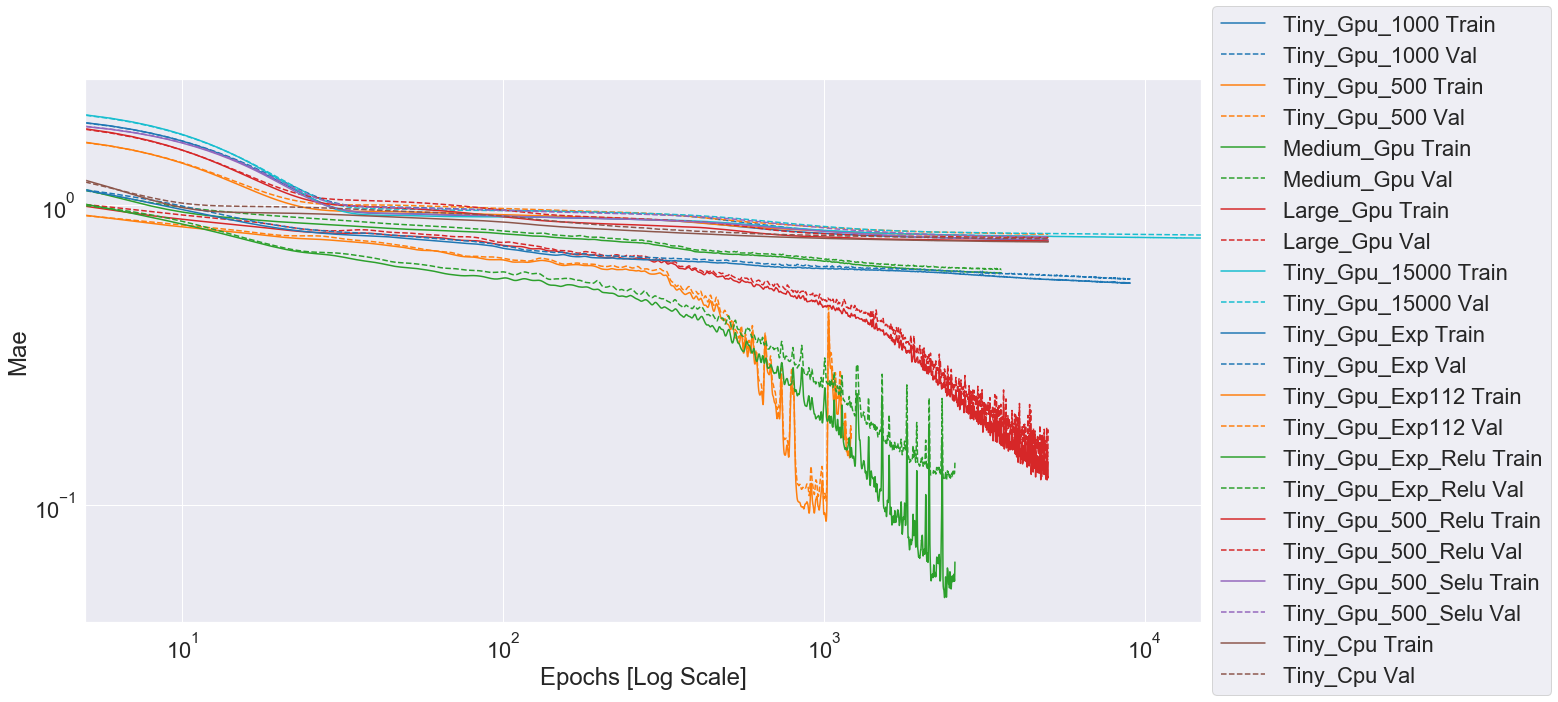

In [168]:
plt.figure(figsize=(20,10))
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.yscale('log')
plt.xlabel("Epochs [Log Scale]")
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [173]:
estimators = list(size_histories.keys())

for i in estimators:
    predicting_nuclear_xs(17, 35-17, size_histories[i].model, N=20, 
                          adopted=True, tf_dataset=True, save=True, name=i)

XS Tree vs EXFOR:
The MSE is:  0.10241385001735825
The R2-Score is:  0.9443646127222964
XS Tree vs EXFOR:
The MSE is:  0.12752825587019578
The R2-Score is:  0.9307214414555662
XS Tree vs EXFOR:
The MSE is:  0.13437006403474924
The R2-Score is:  0.9270046917498362
XS Tree vs EXFOR:
The MSE is:  0.022577481705406247
The R2-Score is:  0.98773498957199
XS Tree vs EXFOR:
The MSE is:  0.12214655031794726
The R2-Score is:  0.9336450037722174
XS Tree vs EXFOR:
The MSE is:  0.18365640531668428
The R2-Score is:  0.90023033765362
XS Tree vs EXFOR:
The MSE is:  0.16444886243338241
The R2-Score is:  0.9106646596401919
XS Tree vs EXFOR:
The MSE is:  0.0384189118974026
The R2-Score is:  0.979129277516296
XS Tree vs EXFOR:
The MSE is:  0.12110945794351417
The R2-Score is:  0.9342083947187012
XS Tree vs EXFOR:
The MSE is:  0.10283087736075018
The R2-Score is:  0.9441380664324043
XS Tree vs EXFOR:
The MSE is:  0.0625454063096244
The R2-Score is:  0.9660227801035944


# Adding Regularization

As we know from Occam's Razor Principle the simplest one is the most likeley to be correct (the one with least amount of assumptions). Similar for neural networks, there will always be multiple models and therefore weights that can explain data. A simple model in this context is a model where the distribution of parameter values has less entropy. A common way to mitigate overfitting is to put constraints on the complexity of the NN by forcing weights to take small values which makes the distribution of such values more regular (weight regularization). This can be done by adding to the loss functionof the network a cost associated with having large weights. This costs can be:
- L1 Regularization: cost added proportional to the absolute value of the weights coefficients (L1 Norm). It pushes weights towards exactly 0 encouraging sparsity.
- L2 Regularization: proportional to the square of the value of the weights coefficients (L2 Norm). It is also called weight decay in NN context. It penalizes weight parameters without making them sparse since the weights go to 0 but are not 0. More common of the two. 

The `regularizers.l2(VALUE)` will make that every coefficient in the weight matrix of the layer will add VALUE * $weight_coefficients_value**2$ to the total loss of the network. In binary classification problems we monitor binary crossentropy since it doesnt have this regularization component mixed in.

Check if l2 is better than large at overfitting (same parameters)?

Dropout one of the most effective and most commonly used for NN. It is based on the fact that individual nodes in the N cannot rely on the output of the otherse, each node must output features that are useful on their own. The drooput layer randomly droppes out (set to zero) a number of output features of the layer during training. Let's say a given layer would normally have returned a vector [0.2, 0.5, 1.3, 0.8, 1.1] for a given input sample during training; after applying dropout, this vector will have a few zero entries distributed at random, e.g. [0, 0.5, 1.3, 0, 1.1]. The dropout rate is the fraction of features that are zeroed out (between 0.2 to 0.5 usually). 

In [109]:
regularizer_histories = {}
regularizer_histories['Tiny_GPU_1000'] = size_histories['Tiny_GPU_1000']

In [110]:
%%time
with gpu_strategy.scope():
    l2_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001),
                     input_shape=(FEATURES,)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(512, activation='elu',
                     kernel_regularizer=regularizers.l2(0.001)),
        layers.Dense(1)
    ])
    
    regularizer_histories['l2'] = compile_and_fit(l2_model, 'regularizers/l2', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 512)               2560      
_________________________________________________________________
dense_28 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_29 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_30 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 513       
Total params: 791,041
Trainable params: 791,041
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:7.5477,  mae:1.8820,  mse:6.0110,  val_loss:4.6718,  val_mae:1.4269,  val_mse:3.5399,  
.........

In [111]:
%%time
with gpu_strategy.scope():
    dropout_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])
    
    regularizer_histories['dropout'] = compile_and_fit(dropout_model, 'regularizers/dropout', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 512)               2560      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 512)             

....................................................................................................
Epoch: 3200, loss:0.6060,  mae:0.5995,  mse:0.6060,  val_loss:0.4822,  val_mae:0.5515,  val_mse:0.5720,  
....................................................................................................
Epoch: 3300, loss:0.6040,  mae:0.5999,  mse:0.6040,  val_loss:0.4664,  val_mae:0.5457,  val_mse:0.5553,  
....................................................................................................
Epoch: 3400, loss:0.6171,  mae:0.5985,  mse:0.6171,  val_loss:0.4794,  val_mae:0.5611,  val_mse:0.5692,  
....................................................................................................
Epoch: 3500, loss:0.6106,  mae:0.6000,  mse:0.6106,  val_loss:0.4584,  val_mae:0.5408,  val_mse:0.5457,  
....................................................................................................
Epoch: 3600, loss:0.5995,  mae:0.5939,  mse:0.5995,  val_loss:0.4545,  

In [112]:
%%time
with gpu_strategy.scope():
    combined_model = tf.keras.Sequential([
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu', input_shape=(FEATURES,)),
        layers.Dropout(0.5),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])
    
    regularizer_histories['combined'] = compile_and_fit(combined_model, 'regularizers/combined', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 512)               2560      
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 512)             

....................................................................................................
Epoch: 3200, loss:0.8058,  mae:0.6462,  mse:0.7203,  val_loss:0.6559,  val_mae:0.6078,  val_mse:0.6718,  
....................................................................................................
Epoch: 3300, loss:0.8141,  mae:0.6481,  mse:0.7286,  val_loss:0.6685,  val_mae:0.6049,  val_mse:0.6807,  
....................................................................................................
Epoch: 3400, loss:0.8060,  mae:0.6447,  mse:0.7205,  val_loss:0.6490,  val_mae:0.6035,  val_mse:0.6624,  
......................................................................................Wall time: 6min 59s


In [119]:
%%time
with gpu_strategy.scope():
    combined_model = tf.keras.Sequential([
        layers.Dense(1000, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu', input_shape=(FEATURES,)),
        layers.Dropout(0.5),
        layers.Dense(1000, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1000, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1000, kernel_regularizer=regularizers.l2(0.0001),
                     activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])
    
    regularizer_histories['combined_1000'] = compile_and_fit(combined_model, 'regularizers/combined_1000', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 1000)              5000      
_________________________________________________________________
dropout_8 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dropout_9 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dropout_10 (Dropout)         (None, 1000)              0         
_________________________________________________________________
dense_45 (Dense)             (None, 1000)            

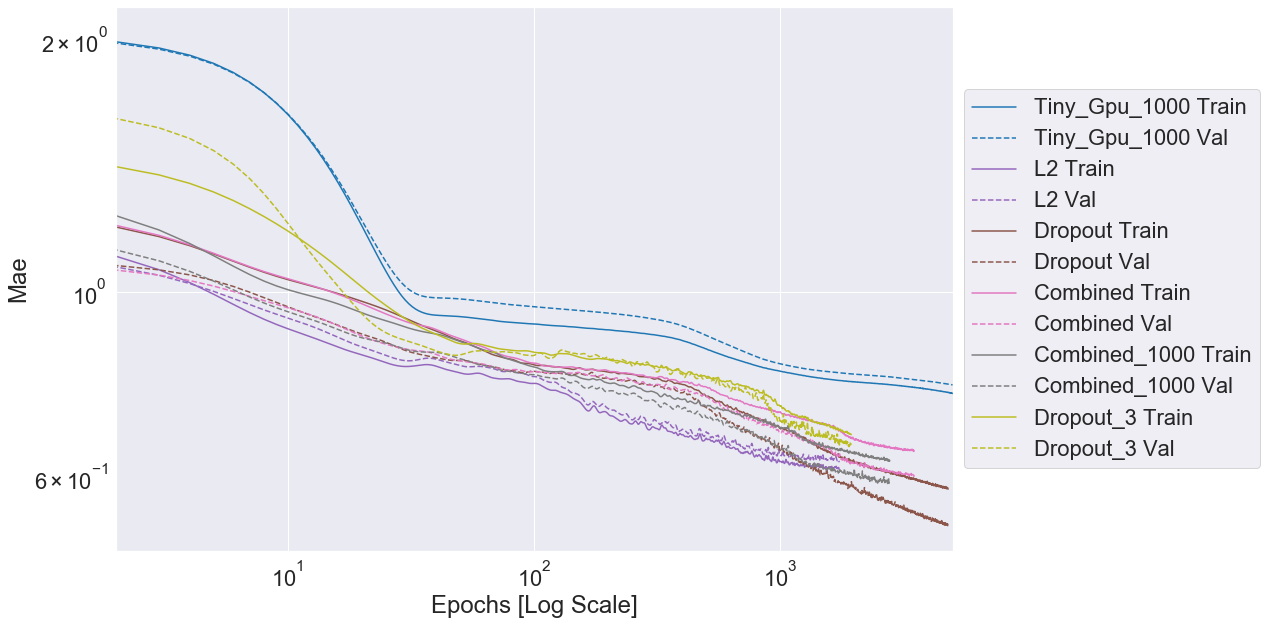

In [169]:
plt.figure(figsize=(15,10))
plotter.plot(regularizer_histories)
a = plt.xscale('log')
plt.xlim([2, max(plt.xlim())])
# plt.ylim([0.5, 0.7])
plt.yscale('log')
plt.xlabel("Epochs [Log Scale]")
# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [121]:
%%time
with gpu_strategy.scope():
    dropout_model = tf.keras.Sequential([
        layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='elu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])
    
    regularizer_histories['dropout_3'] = compile_and_fit(dropout_model, 'regularizers/dropout_3', 
                                                 train_dataset_gpu, test_dataset_gpu, STEPS_PER_EPOCH_GPU, max_epochs=5000)

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_47 (Dense)             (None, 512)               2560      
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 512)             

In [171]:
estimators = list(regularizer_histories.keys())

for i in estimators:
    predicting_nuclear_xs(26, 56-26, regularizer_histories[i].model, N=500, 
                          adopted=True, tf_dataset=True, save=True, name=i)

XS Tree vs EXFOR:
The MSE is:  1.489748418022655
The R2-Score is:  -0.5904657795195134
XS Tree vs EXFOR:
The MSE is:  1.3983296644976708
The R2-Score is:  -0.4928664819946307
XS Tree vs EXFOR:
The MSE is:  1.7203963959652966
The R2-Score is:  -0.8367071660484195
XS Tree vs EXFOR:
The MSE is:  2.1456130397986777
The R2-Score is:  -1.2906714144527065
XS Tree vs EXFOR:
The MSE is:  2.114892282243415
The R2-Score is:  -1.257873719874575
XS Tree vs EXFOR:
The MSE is:  1.70239267863866
The R2-Score is:  -0.8174862721271732


In [290]:
hist = pd.DataFrame(regularizer_histories['l2'].history)
hist['epoch'] = regularizer_histories['l2'].epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
295,3.423054,1.001607,2.655203,2.700178,0.975487,2.573845,295
296,3.360027,1.001824,2.592768,2.696059,0.989105,2.569116,296
297,3.418146,1.010282,2.651459,2.675017,0.977214,2.541878,297
298,3.681805,1.067090,2.915823,2.717230,0.984647,2.599586,298
299,3.674703,1.070685,2.909691,2.951144,1.073622,2.913288,299


## Conclusion

This notebook introduced a few techniques to handle a regression problem.

* Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
* Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
* Early stopping is a useful technique to prevent overfitting.

In [ ]:
# # Include the epoch in the file name (uses `str.format`)
# checkpoint_path = "./Checkpoints/L2/L2/"
# checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
# regularizer_histories['l2'].model.save_weights(checkpoint_dir)

In [227]:
# def predicting_nuclear_xs(protons, neutrons, clf, N=0, adopted=False, tf_dataset=False):
#     ''' 
#     Used to plot predictions of the clf model for specific isotope (Z, N).
#     '''
#     # Extracting dataframe to make predictions and creating copy for evaluation
#     to_plot = df[(df["Protons"] == protons) & (df["Target_Neutrons"] == neutrons)].sort_values(
#         by='Level_Number', ascending=True).drop(columns="Element_w_A")
#     to_infer = df[(df["Protons"] == protons) & (df["Target_Neutrons"] == neutrons)].sort_values(
#         by='Level_Number', ascending=True).drop(columns=["Level_Energy", "Element_w_A"])
    
#     if N != 0:
#         last_level = to_plot.Level_Number.iloc[-1]
#         level_range = np.arange(last_level, last_level + N , 1)
#         to_infer2 = pd.DataFrame({"Level_Number": level_range})
#         for i in list(to_infer.columns)[1:]:
#                 to_infer2[i] = to_infer[i].values[1]
#         to_infer = to_infer.append(to_infer2, ignore_index=True).sort_values(by='Level_Number', ascending=True)

#     if adopted == True:
#         to_plot_2 = df2[(df2["Protons"] == protons) & (df2["Target_Neutrons"] == neutrons) & (df2["Level_Number"] >= last_level)].sort_values(
#             by='Level_Number', ascending=True).drop(
#             columns=["Element_w_A", "Spin", "Parity", "Target_Mass_Number", "Element"])
    
#     # Applying standard scaler method 
#     to_infer[to_scale] = scaler.transform(to_infer[to_scale])
        
#     infer_dataset = tf.data.Dataset.from_tensor_slices(
#         (to_infer.values)).batch(len(to_infer))
#     y_hat  = clf.predict(infer_dataset)

#     # Returning features to original values for plotting
#     to_infer[to_scale] = scaler.inverse_transform(to_infer[to_scale])
        
#     # Initializing Figure and Plotting 
#     plt.figure(figsize=(16,10))
#     true = plt.scatter(to_plot["Level_Number"], to_plot["Level_Energy"], alpha=0.3, c='b')
#     if adopted == True:
#         adopted_plot = plt.scatter(to_plot_2["Level_Number"], to_plot_2["Level_Energy"], alpha=0.3, c='g')
#     pred = plt.scatter(to_infer["Level_Number"], y_hat.flatten(), alpha=0.5, label="Pred", c="orange")
#     plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
#     plt.ylabel('Level Energy (MeV)')
#     plt.xlabel('Level Number')
#     plt.legend((true, pred), ('ENSDF', "NN ENSDF Pred"), loc='upper left')    
#     all_y = np.concatenate((to_plot["Level_Energy"], y_hat.flatten()))
#     minimum_y = all_y[all_y > 0].min() - all_y[all_y > 0].min() * 0.05 
#     maximum_y = all_y.max() + all_y.max() * 0.05
#     plt.ylim(minimum_y, maximum_y)
#     plt.show()
    
#     if N != 0:
#         print("XS Tree vs EXFOR:")
#         print("The MSE is: ", mean_squared_error(to_plot["Level_Energy"], y_hat.flatten()[:last_level]))
#         print("The R2-Score is: ", r2_score(to_plot["Level_Energy"], y_hat.flatten()[:last_level]))
#     else:
#         print("XS Tree vs EXFOR:")
#         print("The MSE is: ", mean_squared_error(to_plot["Level_Energy"], y_hat.flatten()))
#         print("The R2-Score is: ", r2_score(to_plot["Level_Energy"], y_hat.flatten()))    

#     if (N != 0 and adopted == True):
#         print("hello")
#         plt.figure(figsize=(16,10))     
#         count, division = np.histogram(to_plot.Level_Energy, bins=binning)
#         kwargs = dict(ec="k", histtype='stepfilled', alpha=0.5, bins=division)
#         histogram_og = pd.DataFrame(to_plot.Level_Energy.values, columns=["Level_Energy"])
#         histogram_og.Level_Energy.hist(color="green", label="Cut-Off", **kwargs)
#         histogram_new = pd.DataFrame(y_hat.flatten(), columns=["Level_Energy"])
#         histogram_new.Level_Energy.hist(color="lightblue", label="Predictions", **kwargs)
#         histogram_ad = pd.DataFrame(to_plot_2.Level_Energy.values, columns=["Level_Energy"])
#         histogram_ad.Level_Energy.hist(color="salmon", label="Adopted", **kwargs)
#         plt.legend()
#         plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
#         plt.xlabel('Energy (MeV)')
#         plt.yscale('log')
#     elif (N != 0 and adopted == False):
#         print('hello2')
#         plt.figure(figsize=(16,10))     
#         count, division = np.histogram(to_plot.Level_Energy, bins=binning)
#         kwargs = dict(ec="k", histtype='stepfilled', alpha=0.5, bins=division)
#         histogram_og = pd.DataFrame(to_plot.Level_Energy.values, columns=["Level_Energy"])
#         histogram_og.Level_Energy.hist(color="green", label="Cut-Off", **kwargs)
#         histogram_new = pd.DataFrame(y_hat.flatten(), columns=["Level_Energy"])
#         histogram_new.Level_Energy.hist(color="lightblue", label="Predictions", **kwargs)
#         plt.legend()
#         plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
#         plt.xlabel('Energy (MeV)')
#     else:
#         print("what")
#         plt.figure(figsize=(16,10))     
#         count, division = np.histogram(to_plot.Level_Energy, bins=binning)
#         histogram = pd.DataFrame(y_hat, columns=["Level_Energy"])
#         histogram.Level_Energy.hist(bins=division)
#         plt.title('{} Protons, {} Neutrons'.format(protons, neutrons))
#         plt.xlabel('Energy (MeV)')